In [19]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(r'C:\Users\jinho.kim\Github\lamf_ophys_analysis_dev')
from utils import zstack_reg
import stitching_2p_fullfield
from tifffile import imread
import tifffile

In [23]:
from PIL import Image
from PIL.TiffTags import TAGS
with Image.open(fn) as img:
    meta_dict = {TAGS[key] : img.tag[key] for key in img.tag_v2}


In [6]:
meta_dict

{'ImageWidth': (208,),
 'ImageLength': (3384,),
 'BitsPerSample': (16,),
 'Compression': (1,),
 'PhotometricInterpretation': (1,),
 'ImageDescription': ('frameNumbers = 1\nacquisitionNumbers = 1\nframeNumberAcquisition = 1\nframeTimestamps_sec = 0.000000000\nacqTriggerTimestamps_sec = -0.000056430\nnextFileMarkerTimestamps_sec = -1.000000000\nendOfAcquisition = 0\nendOfAcquisitionMode = 0\ndcOverVoltage = 0\nepoch = [2024  4 26 11 13 27.098]\nauxTrigger0 = []\nauxTrigger1 = []\nauxTrigger2 = []\nauxTrigger3 = []\nI2CData = {}\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [24]:
from pprint import pprint
pprint(meta_dict['Artist'])

('{\n'
 '  "RoiGroups": {\n'
 '    "imagingRoiGroup": {\n'
 '      "ver": 1,\n'
 '      "classname": "scanimage.mroi.RoiGroup",\n'
 '      "name": "MROI Imaging ROI Group",\n'
 '      "UserData": null,\n'
 '      "roiUuid": "A5DA895BB5B8231",\n'
 '      "roiUuiduint64": 7.469384743e+17,\n'
 '      "rois": [\n'
 '        {\n'
 '          "ver": 1,\n'
 '          "classname": "scanimage.mroi.Roi",\n'
 '          "name": "ROI 1",\n'
 '          "UserData": null,\n'
 '          "roiUuid": "1788FB8DEA053B55",\n'
 '          "roiUuiduint64": 1.695881847e+18,\n'
 '          "zs": -31,\n'
 '          "scanfields": {\n'
 '            "ver": 1,\n'
 '            "classname": '
 '"scanimage.mroi.scanfield.fields.RotatedRectangle",\n'
 '            "name": "",\n'
 '            "UserData": null,\n'
 '            "roiUuid": "71D2F12E1382223E",\n'
 '            "roiUuiduint64": 8.201883052e+18,\n'
 '            "centerXY": [-13.07338965,-0.8363252376],\n'
 '            "sizeXY": [4.053854277,15.797254

In [7]:
from pprint import pprint
pprint(meta_dict['Software'])

("SI.ConfigPageClass = 'dabs.resources.configuration.resourcePages.SIPage'\n"
 'SI.LINE_FORMAT_VERSION = 1\n'
 'SI.PREMIUM = true\n'
 'SI.TIFF_FORMAT_VERSION = 4\n'
 "SI.VERSION_COMMIT = '56c3afc1bf090313ec49069b93dab351ee92fd74'\n"
 'SI.VERSION_MAJOR = 2020\n'
 'SI.VERSION_MINOR = 1\n'
 'SI.VERSION_UPDATE = 4\n'
 "SI.acqState = 'grab'\n"
 'SI.acqsPerLoop = 1\n'
 "SI.errorMsg = ''\n"
 'SI.extTrigEnable = 0\n'
 'SI.fieldCurvatureRxs = []\n'
 'SI.fieldCurvatureRys = []\n'
 'SI.fieldCurvatureTilt = 0\n'
 'SI.fieldCurvatureTip = 0\n'
 'SI.fieldCurvatureZs = []\n'
 'SI.hBeams.enablePowerBox = false\n'
 "SI.hBeams.errorMsg = ''\n"
 'SI.hBeams.flybackBlanking = true\n'
 'SI.hBeams.hBeamRouters = {}\n'
 "SI.hBeams.hBeams = {'Total' 'Split'}\n"
 'SI.hBeams.hReserver = []\n'
 'SI.hBeams.hUsers = {}\n'
 'SI.hBeams.interlaceDecimation = [1 1]\n'
 'SI.hBeams.interlaceOffset = [0 0]\n'
 'SI.hBeams.lengthConstants = [180 Inf]\n'
 "SI.hBeams.name = 'SI Beams'\n"
 'SI.hBeams.powerBoxEndFrame = Inf\n'
 

In [2]:
fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')

stitched = stitching_2p_fullfield.stitch_fullfield(fn)

In [4]:
stitched.shape

(846, 832)

TypeError: Invalid shape (520, 846, 832) for image data

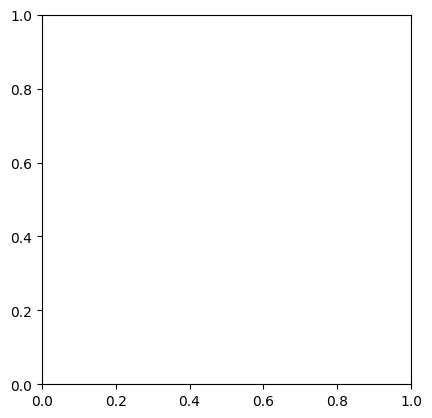

In [16]:
from matplotlib import pyplot as plt
plt.imshow(fullfield_)

In [6]:
fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')

num_slices, num_volumes, num_columns = stitching_2p_fullfield.read_si_fullfield_metadata(fn)
fullfield_all = imread(fn)

In [8]:
num_rows = int((fullfield_all.shape[1]+1) / num_columns)

In [9]:
num_rows

846

In [4]:
num_volumes

20

In [11]:
ind = np.hstack([np.arange(i, fullfield_all.shape[0], num_slices) for i in range(num_slices)])

In [49]:
fullfield_ = np.concatenate([fullfield_all[ind,:,:],np.zeros((fullfield_all.shape[0],1,fullfield_all.shape[2]))], axis=1) 

In [50]:
fullfield_ = fullfield_all[ind,:,:] 
fullfield_stitched = np.concatenate([np.roll(fullfield_[:, i*num_rows : (i+1)*num_rows, :], -i*12, axis=1) for i in range(num_columns)],axis=2)

In [39]:
fullfield_stitched.shape

(520, 846, 832)

In [43]:
num_slices

26

In [51]:
ff_zstack = np.stack([fullfield_stitched[i*num_slices : (i+1)*num_slices, :, :].mean(axis=0) for i in range(20)])

In [31]:
ff_zstack.shape

(26, 846, 832)

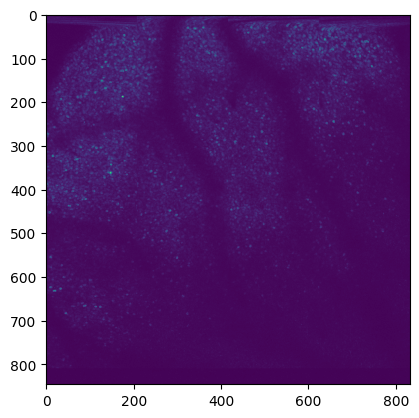

In [52]:
plt.imshow(ff_zstack[10])

In [53]:
save_fn = Path(r'\\allen\programs\mindscope\workgroups\learning\pilots\GCaMP8\AAV_local') / 'temp_stitched_zstack.tif'
tifffile.imsave(save_fn, ff_zstack)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_7172\3830217420.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(save_fn, ff_zstack)


In [7]:
fn = Path(r'\\allen\programs\braintv\workgroups\ophysdev\OPhysCore\operator_files\shiella_caldejon\719363\719363_V1_localized_stack_00001.tif')
zstack_reg.read_si_stack_metadata(fn)

{'num_slices': 16,
 'num_volumes': 20,
 'actuator': 'fastZ',
 'num_channels': 1,
 'z_values': array([-51., -31., -11.,   9.,  29.,  49.,  69.,  89., 109., 129., 149.,
        169., 189., 209., 229., 249., 269., 289., 309., 329., 349., 369.,
        389., 409., 429., 449.])}